In [1]:
#!/usr/bin/env python
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np, os, sys
from tqdm.notebook import tqdm    
from manipulations import get_Datas, segment_QRS, get_scored_class
from sklearn.model_selection import KFold, StratifiedKFold

In [2]:
N_CLASS = 27

In [3]:
MAX_RR = 500 # 60 beats/min => 60 beats/60 s ==> beat/1s ==> 500 samples / beat

In [6]:
Datas, Codes, dataset_train_idx, dataset_test_idx = get_Datas()

Dataset  1


/home/yfeng/anaconda3/envs/physioNet/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Done.
Dataset  2



Done.
Dataset  3


/home/yfeng/anaconda3/envs/physioNet/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning



Done.
Dataset  4


/home/yfeng/anaconda3/envs/physioNet/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning



Done.
Dataset  5


/home/yfeng/anaconda3/envs/physioNet/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


/home/yfeng/anaconda3/envs/physioNet/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Done.
Dataset  6


/home/yfeng/anaconda3/envs/physioNet/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Done.


In [7]:
from global_vars import labels, Dx_map, Dx_map_unscored, equivalent_mapping

In [8]:
datasets = [1, 2]
all_train_idx = []
for dataset in datasets:
    all_train_idx.extend(dataset_train_idx[dataset])
    
all_test_idx = []
for dataset in datasets:
    all_test_idx.extend(dataset_test_idx[dataset])

# Segmentation

In [9]:
from saved_data_io import read_file
Q_locs = read_file('Q_locs')

read from ../saved/newData_Q_locs_1000_7000_peakdist100.pkl


In [10]:
len(Codes)

43101

In [11]:
data_labels = np.array([get_scored_class(Codes[idx], labels) for idx in all_train_idx + all_test_idx])
print(data_labels.shape)

(10330, 27)


In [12]:
key_idxes = []
for key in equivalent_mapping.keys():
    print(key)
    key_idx = np.argwhere(labels==int(key)).flatten()[0]
    key_idxes.append(key_idx)
    val_idx = np.argwhere(labels==int(equivalent_mapping[key])).flatten()[0]
    key_pos = np.argwhere(data_labels[:,key_idx]==1).flatten()
    val_pos = np.argwhere(data_labels[:,val_idx]==1).flatten()
    data_labels[key_pos,val_idx] = 1
    data_labels[val_pos,key_idx] = 1

713427006
284470004
427172004


In [13]:
# non_empty_idx = np.argwhere(np.sum(data_labels, axis=1)!=0).flatten()
# empty_idx = np.argwhere(np.sum(data_labels, axis=1)==0).flatten()

In [14]:
X_train = []
Data_labels_train = []
Idxes_train = []
Idxes_dict_train = {}
ct = 0
for i in tqdm(all_train_idx):
    Q_loc = Q_locs[i]
    RR_avg = np.median([Q_loc[k+1] - Q_loc[k] for k in range(len(Q_loc)-1)])
    RR_th = (0.3 * RR_avg, 3 * RR_avg)
    
    ks = [k for k in range(len(Q_loc)-1) if Q_loc[k+1] - Q_loc[k] > RR_th[0] 
              and Q_loc[k+1] - Q_loc[k] < RR_th[1]]
    
    
    Idxes_dict_train[i] = []
    for k in ks:
        Data_labels_train.append(data_labels[i])
        X_train.append(Datas[i][:,Q_loc[k]:Q_loc[k+1]])
        Idxes_train.append(i)
        Idxes_dict_train[i].append(ct)
        
    ct += 1

/home/yfeng/anaconda3/envs/physioNet/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/yfeng/anaconda3/envs/physioNet/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [15]:
X_test = []
Data_labels_test = []
Idxes_test = []
Idxes_dict_test = {}
ct = 0
for i in tqdm(all_test_idx):
        
    Q_loc = Q_locs[i]
    RR_avg = np.median([Q_loc[k+1] - Q_loc[k] for k in range(len(Q_loc)-1)])
    RR_th = (0.3 * RR_avg, 3 * RR_avg)
    
    ks = [k for k in range(len(Q_loc)-1) if Q_loc[k+1] - Q_loc[k] > RR_th[0] 
              and Q_loc[k+1] - Q_loc[k] < RR_th[1]]
    
    
    Idxes_dict_test[i] = []
    for k in ks:
        Data_labels_test.append(data_labels[i])
        X_test.append(Datas[i][:,Q_loc[k]:Q_loc[k+1]])
        Idxes_test.append(i)
        Idxes_dict_test[i].append(ct)
        
    ct += 1

In [16]:
from sklearn.preprocessing import normalize
Signals_train = np.zeros((len(X_train),12,MAX_RR))
for i in range(len(X_train)):
    Signals_train[i,:,:min(len(X_train[i][0]),MAX_RR)] = normalize(X_train[i][:,:min(len(X_train[i][0]),MAX_RR)], axis=1)
    
    

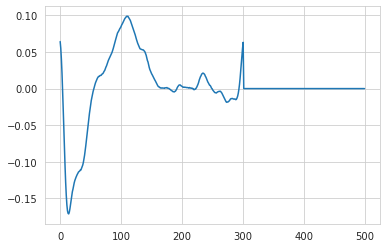

In [17]:
plt.plot(Signals_train[10][0])

In [18]:
from sklearn.preprocessing import normalize
Signals_test = np.zeros((len(X_test),12,MAX_RR))
for i in range(len(X_test)):
    Signals_test[i,:,:min(len(X_test[i][0]),MAX_RR)] = normalize(X_test[i][:,:min(len(X_test[i][0]),MAX_RR)], axis=1)
    

# On y va

In [20]:
run_name = 'ECGResNet_new_500RR_effectiveclass_12chn_normalized_1_nosampler_batchsize64_dataset1+2'

In [21]:
from torch.utils.tensorboard import SummaryWriter

# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('runs/{}'.format(run_name))


In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

In [23]:
import torch
from torch import nn

In [24]:
class_idx = np.argwhere(np.sum(Data_labels_train,axis=0)!=0).flatten()

In [25]:
Signal_12leads_train = Signals_train
Signal_12leads_test= Signals_train 

In [26]:
Signal_12leads_train.shape

(97615, 12, 500)

In [27]:
from torch.utils.data import Dataset
from torchvision import transforms

import os
class SignalDataset(Dataset):

    def __init__(self, signals, labels):
        self.signals = signals
        self.labels = labels

    def __len__(self):
        return len(self.signals)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        sample =(torch.cat([torch.Tensor(np.array([self.signals[idx,channel]])) for channel in range(12)], axis=0), 
                  torch.Tensor(self.labels[idx]))

        return sample
    
signal_datasets_train = SignalDataset(Signal_12leads_train[:,:,:MAX_RR], np.array(Data_labels_train)[:,class_idx])
signal_datasets_test = SignalDataset(Signal_12leads_test[:,:,:MAX_RR], np.array(Data_labels_test)[:,class_idx])


In [28]:
assert len(signal_datasets_train[0][1]) == len(class_idx)

In [29]:
signal_datasets_train[0][0].shape

torch.Size([12, 500])

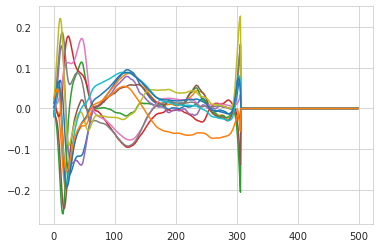

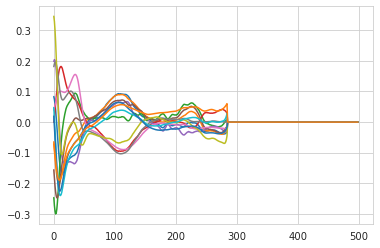

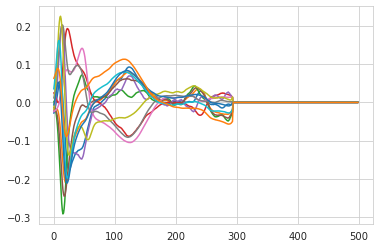

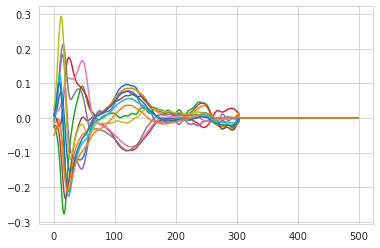

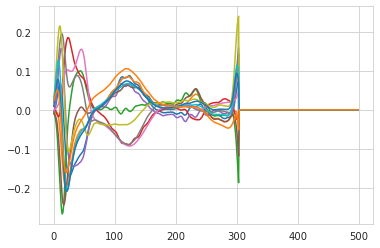

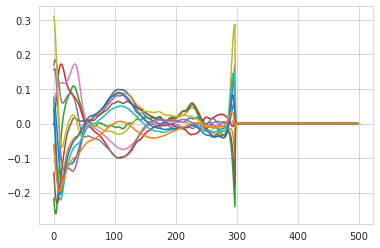

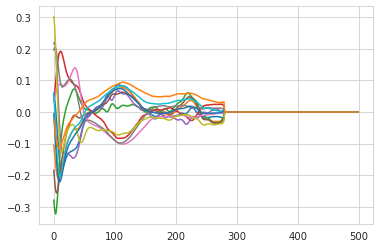

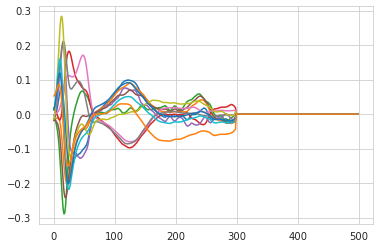

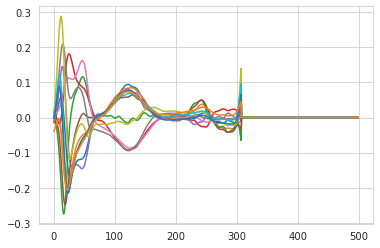

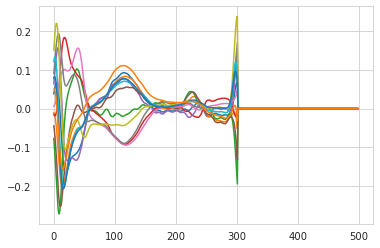

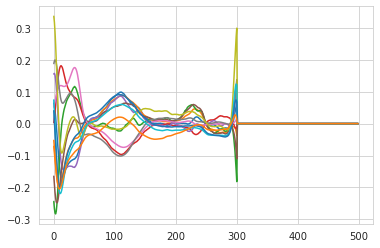

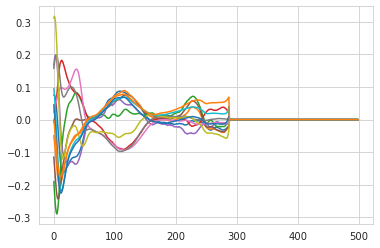

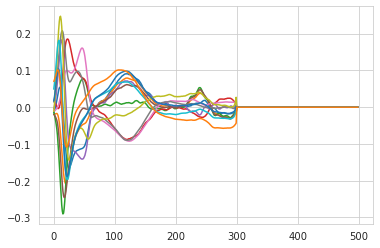

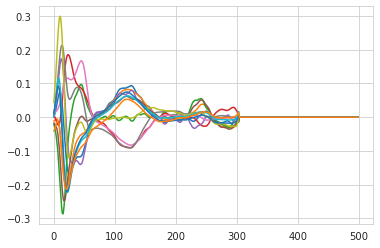

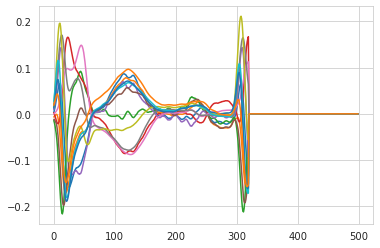

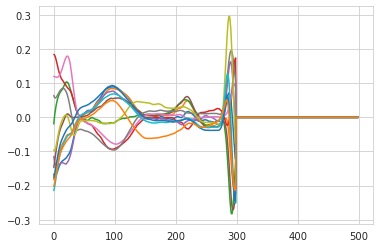

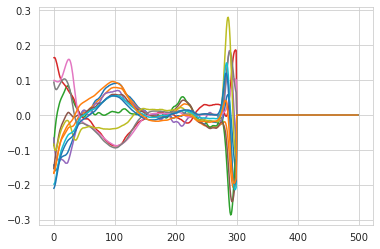

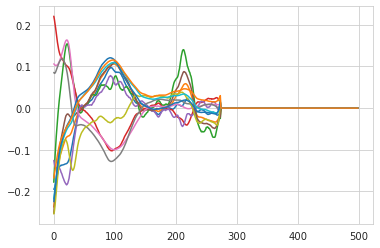

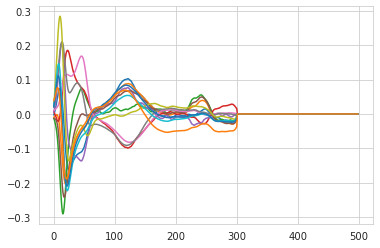

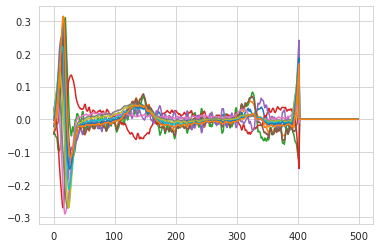

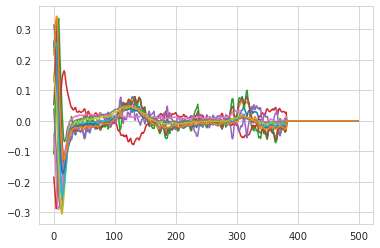

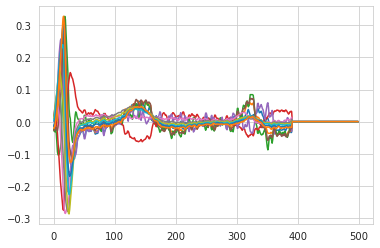

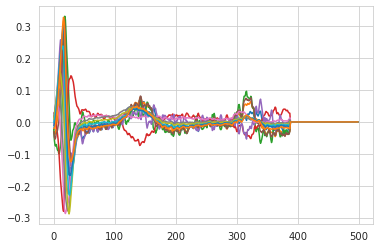

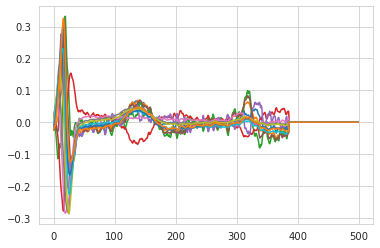

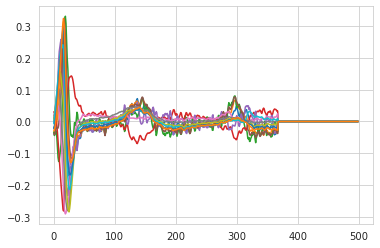

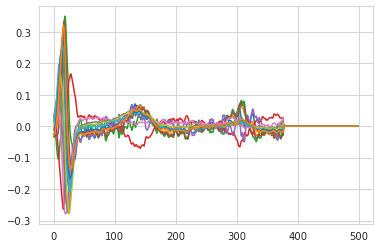

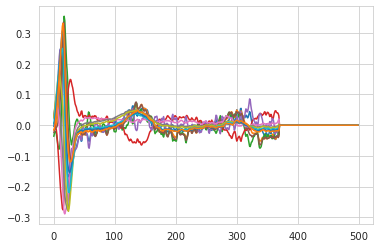

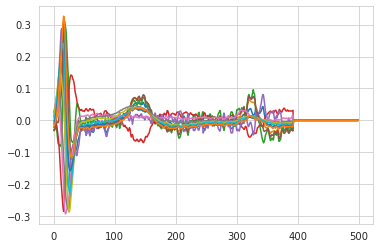

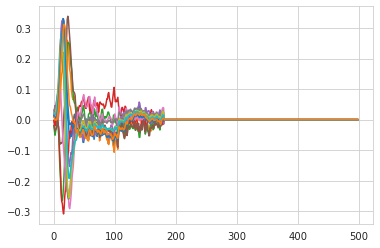

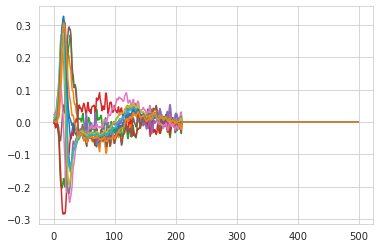

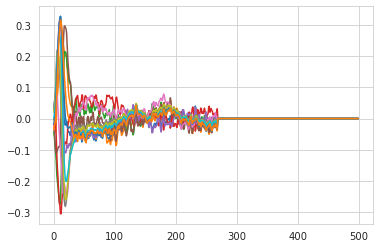

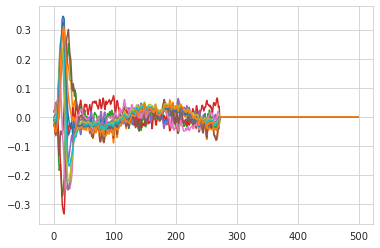

In [30]:
for idx in range(32):
    [plt.plot(signal_datasets_train[idx][0][i]) for i in range(12)] 
    plt.show()

In [31]:
from global_vars import weights

In [32]:
weights_tensor = torch.Tensor(weights).to(device)

In [33]:
from pytorch_training import add_pr_curve_tensorboard

In [34]:
import torch
dummy = torch.ones((10, 12, MAX_RR))
dummy2 = torch.ones((10, MAX_RR, 12))

In [35]:
from resnet1d import ECGResNet
model = ECGResNet(12, len(class_idx), n=1)

In [36]:
model(dummy).shape

torch.Size([10, 22])

In [37]:
from torchvision import datasets, models, transforms
from myeval import agg_y_preds_bags, binary_acc, geometry_loss, compute_score
import torch.optim as optim
from torch.optim import lr_scheduler
from snippets.pytorchtools import EarlyStopping
import time

st = time.time()
patience = 50
batch_size= 64#65000

saved_dir = '../saved/ECGResNet/'
model.to(device)



ECGResNet(
  (encoder): ResNetEncoder(
    (gate): Sequential(
      (0): Conv1d(12, 64, kernel_size=(7,), stride=(2,), padding=(3,), bias=False)
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool1d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (blocks): ModuleList(
      (0): ResNetLayer(
        (blocks): Sequential(
          (0): ResNet753Block(
            (blocks): Sequential(
              (0): Sequential(
                (0): Conv1dAuto(64, 64, kernel_size=(7,), stride=(1,), padding=(3,), bias=False)
                (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              )
              (1): ReLU(inplace=True)
              (2): Sequential(
                (0): Conv1dAuto(64, 64, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
                (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

In [38]:
from imbalanced_weights import cal_multilabel_weights, inverse_weight
sample_weights, Data_labels_train_new, label_to_count, new_index_dict= cal_multilabel_weights(Data_labels_train, 0)

In [39]:
from imbalanced_sampler import  WeightedImbalancedDatasetSampler
trainDataset = torch.utils.data.Subset(signal_datasets_train, range(0,len(Signals_train), 1))
testDataset = torch.utils.data.Subset(signal_datasets_test, range(0,len(Signals_test), 1))

trainLoader = torch.utils.data.DataLoader(trainDataset, batch_size=batch_size, pin_memory=True, shuffle=True)
                                     #  sampler=WeightedImbalancedDatasetSampler(trainDataset, weights=sample_weights))
testLoader = torch.utils.data.DataLoader(testDataset, batch_size=3000, shuffle = False, pin_memory=True)

In [40]:
train_class_weight = torch.Tensor(inverse_weight(Data_labels_train, class_idx)).to(device)
test_class_weight = torch.Tensor(inverse_weight(Data_labels_test, class_idx)).to(device)
criterion_train = nn.BCEWithLogitsLoss(reduction='mean')#, weight=train_class_weight) 
criterion_test = nn.BCEWithLogitsLoss(reduction='mean')#, weight=test_class_weight) 

/home/yfeng/Project/CinC2020/source/imbalanced_weights.py:69: RuntimeWarning: divide by zero encountered in true_divide
  inv_class_weights = 1.0/np.sum(Data_labels, axis=0)[class_idx]
/home/yfeng/Project/CinC2020/source/imbalanced_weights.py:70: RuntimeWarning: invalid value encountered in true_divide
  inv_class_weights = inv_class_weights / np.sum(inv_class_weights)


In [41]:
early_stopping = EarlyStopping(patience, verbose=False, 
                              saved_dir=saved_dir, 
                              save_name=run_name)

In [42]:
optimizer = optim.Adam(model.parameters(), lr=0.01) 
#optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9) #
# Decay LR by a factor of 0.1 every 100 epochs
#scheduler = lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=20, mode='max')

In [44]:
from manipulations import get_name
names = [get_name(label, Dx_map, Dx_map_unscored) for label in labels]
names = np.array(names)[class_idx]
from global_vars import normal_class
normal_idx = np.argwhere(names==int(normal_class))

y_trains_tensor = None
y_tests_tensor = None
losses_train = []
avg_losses_train = []
losses_test = []
avg_losses_test = []
for epoch in range(0, 5000):

    model.train()

    running_loss_train = 0.0

    y_trains = [] # ground truth
    output_trains = [] # output
    for k, (X_train, y_train) in tqdm(enumerate(trainLoader)):
        y_train = y_train.to(device)
        X_train = X_train.to(device)
        optimizer.zero_grad()
        output_train = model(X_train)
        output_trains.append(output_train.cpu())
        
        loss_train = criterion_train(output_train, y_train)
        losses_train.append(loss_train.item())
        
        avg_loss_train = np.average(losses_train)
        avg_losses_train.append(avg_loss_train)
    
        
        if np.mod(k, 100) == 0:
            writer.add_scalar('train/loss',
            avg_loss_train,
            epoch * (len(Data_labels_train)//batch_size//100+1) + k//100)
        
        y_trains.append(y_train.cpu())
            
        loss_train.backward()
        optimizer.step()
            
    #scheduler.step()
    

    y_tests = [] # ground truth
    output_tests = [] # output
    with torch.no_grad():
        model.eval()
        
        for X_test, y_test in testLoader:  
            y_test = y_test.to(device)
            X_test = X_test.to(device)
            output_test = model(X_test)

            loss_test = criterion_test(output_test, y_test)
            losses_test.append(loss_test.item())

            output_tests.append(output_test.cpu())
            y_tests.append(y_test.cpu())
            
            
            
        avg_loss_test = np.average(losses_test)
        avg_losses_test.append(avg_loss_test)

        writer.add_scalar('test/loss',
                avg_loss_test,
                epoch)



    y_trains_tensor = torch.cat(y_trains, axis=0) # ground truth
    y_tests_tensor = torch.cat(y_tests, axis=0) # ground truth

    output_trains = torch.cat(output_trains, axis=0) 
    y_train_preds = torch.sigmoid(output_trains)

    output_tests = torch.cat(output_tests, axis=0)
    y_test_preds = torch.sigmoid(output_tests)

    #output_trains = torch.cat(output_trains, axis=0)
#     y_train_preds_max, y_train_preds_mean, _ = agg_y_preds_bags(y_train_preds, bag_size=n_segments)
#     y_test_preds_max, y_test_preds_mean, _ = agg_y_preds_bags(y_test_preds, bag_size=n_segments)
#     _, _, y_trains = agg_y_preds_bags(y_trains, bag_size=n_segments)
#     _, _, y_tests = agg_y_preds_bags(y_tests, bag_size=n_segments)


    for class_i_idx in range(len(class_idx)):
        add_pr_curve_tensorboard(writer, class_i_idx, y_trains_tensor, y_train_preds, names, global_step=epoch, prefix='train/')
        add_pr_curve_tensorboard(writer, class_i_idx, y_tests_tensor, y_test_preds, names, global_step=epoch, prefix='test/')



    acc, fmeasure, fbeta, gbeta = binary_acc(y_train_preds, y_trains_tensor)           
    acc2, fmeasure2, fbeta2, gbeta2 = binary_acc(y_test_preds, y_tests_tensor)
    geometry = geometry_loss(fbeta, gbeta)
    geometry2 = geometry_loss(fbeta2, gbeta2)
    
#     output_str = 'S{} {:.2f} min |\n Train Loss: {:.6f}, Acc: {:.3f}, F: {:.3f}, Fbeta: {:.3f}, gbeta: {:.3f}, geo: {:.3f}, score: {:.3f} |\n Valid Loss: {:.6f}, Acc: {:.3f}, F: {:.3f}, Fbeta: {:.3f}, gbeta: {:.3f}, geo: {:.3f}, score: {:.3f}\n '.format(
#         epoch, (time.time()-st)/60,
#         avg_loss_train, acc, fmeasure, fbeta, gbeta, geometry, np.nan,
#         avg_loss_test, acc2, fmeasure2, fbeta2, gbeta2, geometry2, np.nan)
#     print(output_str)
    score = compute_score(np.round(y_train_preds.data.numpy()), np.round(y_trains_tensor.data.numpy()),  weights, class_idx, normal_idx)
    score2 = compute_score(np.round(y_test_preds.data.numpy()), np.round(y_tests_tensor.data.numpy()), weights, class_idx, normal_idx)
    output_str = 'S{} {:.2f} min |\n Train Loss: {:.6f}, Acc: {:.3f}, F: {:.3f}, Fbeta: {:.3f}, gbeta: {:.3f}, geo: {:.3f}, score: {:.3f} |\n Valid Loss: {:.6f}, Acc: {:.3f}, F: {:.3f}, Fbeta: {:.3f}, gbeta: {:.3f}, geo: {:.3f}, score: {:.3f}\n '.format(
        epoch, (time.time()-st)/60,
        avg_loss_train, acc, fmeasure, fbeta, gbeta, geometry, score,
        avg_loss_test, acc2, fmeasure2, fbeta2, gbeta2, geometry2, score2)
    scheduler.step(score2)
    
    writer.add_scalar('train/score',
            score,
            epoch)

    writer.add_scalar('test/score',
            score2,
            epoch)
    
    print(output_str)

    with open(saved_dir+'loss_{}.txt'.format(run_name), 'a') as f:
        print(output_str, file=f)

    early_stopping(-score2, model)

    if early_stopping.early_stop:
        print("Early stopping")
        break


#     output_string = 'AUROC|AUPRC|Accuracy|F-measure|Fbeta-measure|Gbeta-measure|Geomotry\n{:.3f}|{:.3f}|{:.3f}|{:.3f}|{:.3f}|{:.3f}|{:.3f}'.format(auroc2,auprc2,acc2,fmeasure2,fbeta2,gbeta2,geometry2)
#     print(output_string)     
#     with open(saved_dir+'score'+ str(i)+ '_epoch' + str(epoch) + '.txt', 'w') as f:
#         f.write(output_string)

#     avg_losses_train = np.array(avg_losses_train)
#     avg_losses_test = np.array(avg_losses_test)

#     np.save(saved_dir + 'avg_losses_train' + str(i) + '_epoch' + str(epoch), avg_losses_train)
#     np.save(saved_dir + 'avg_losses_test' + str(i) + '_epoch' + str(epoch), avg_losses_test)


/home/yfeng/anaconda3/envs/physioNet/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  """



S0 1.85 min |
 Train Loss: 0.145928, Acc: 0.956, F: 0.000, Fbeta: 0.000, gbeta: 0.000, geo: 0.000, score: 0.067 |
 Valid Loss: 0.146392, Acc: 0.955, F: 0.136, Fbeta: 0.136, gbeta: 0.136, geo: 0.136, score: nan
 



S1 2.96 min |
 Train Loss: 0.145094, Acc: 0.956, F: 0.000, Fbeta: 0.000, gbeta: 0.000, geo: 0.000, score: nan |
 Valid Loss: 0.146192, Acc: 0.955, F: 0.136, Fbeta: 0.136, gbeta: 0.136, geo: 0.136, score: nan
 



S2 4.08 min |
 Train Loss: 0.144660, Acc: 0.956, F: 0.000, Fbeta: 0.000, gbeta: 0.000, geo: 0.000, score: nan |
 Valid Loss: 0.145858, Acc: 0.955, F: 0.136, Fbeta: 0.136, gbeta: 0.136, geo: 0.136, score: 0.000
 



S3 5.20 min |
 Train Loss: 0.144294, Acc: 0.956, F: 0.000, Fbeta: 0.000, gbeta: 0.000, geo: 0.000, score: 0.511 |
 Valid Loss: 0.146107, Acc: 0.955, F: 0.140, Fbeta: 0.141, gbeta: 0.138, geo: 0.140, score: 0.453
 



S4 6.31 min |
 Train Loss: 0.143899, Acc: 0.956, F: 0.000, Fbeta: 0.000, gbeta: 0.000, geo: 0.000, score: 0.567 |
 Valid Loss: 0.146354, Acc: 0.955, F: 0.137, Fbeta: 0.137, gbeta: 0.136, geo: 0.137, score: 0.342
 



S5 7.22 min |
 Train Loss: 0.143443, Acc: 0.956, F: 0.001, Fbeta: 0.002, gbeta: 0.001, geo: 0.001, score: 0.632 |
 Valid Loss: 0.146771, Acc: 0.955, F: 0.137, Fbeta: 0.137, gbeta: 0.136, geo: 0.137, score: 0.335
 



S6 8.34 min |
 Train Loss: 0.142840, Acc: 0.956, F: 0.004, Fbeta: 0.006, gbeta: 0.002, geo: 0.003, score: 0.685 |
 Valid Loss: 0.147457, Acc: 0.955, F: 0.137, Fbeta: 0.137, gbeta: 0.137, geo: 0.137, score: 0.285
 



S7 9.42 min |
 Train Loss: 0.142026, Acc: 0.956, F: 0.008, Fbeta: 0.012, gbeta: 0.003, geo: 0.006, score: 0.699 |
 Valid Loss: 0.148156, Acc: 0.954, F: 0.138, Fbeta: 0.139, gbeta: 0.137, geo: 0.138, score: 0.318
 



S8 10.54 min |
 Train Loss: 0.140891, Acc: 0.957, F: 0.019, Fbeta: 0.027, gbeta: 0.008, geo: 0.015, score: 0.700 |
 Valid Loss: 0.150038, Acc: 0.953, F: 0.139, Fbeta: 0.140, gbeta: 0.137, geo: 0.139, score: 0.295
 



S9 11.66 min |
 Train Loss: 0.139378, Acc: 0.958, F: 0.057, Fbeta: 0.081, gbeta: 0.025, geo: 0.045, score: 0.742 |
 Valid Loss: 0.152391, Acc: 0.949, F: 0.145, Fbeta: 0.148, gbeta: 0.140, geo: 0.144, score: 0.334
 



S10 12.79 min |
 Train Loss: 0.137514, Acc: 0.959, F: 0.115, Fbeta: 0.156, gbeta: 0.054, geo: 0.092, score: 0.752 |
 Valid Loss: 0.155347, Acc: 0.948, F: 0.146, Fbeta: 0.149, gbeta: 0.140, geo: 0.144, score: 0.321
 



S11 13.92 min |
 Train Loss: 0.135346, Acc: 0.961, F: 0.193, Fbeta: 0.250, gbeta: 0.097, geo: 0.156, score: 0.768 |
 Valid Loss: 0.158402, Acc: 0.944, F: 0.153, Fbeta: 0.156, gbeta: 0.143, geo: 0.149, score: 0.336
 



S12 15.06 min |
 Train Loss: 0.132906, Acc: 0.963, F: 0.270, Fbeta: 0.333, gbeta: 0.142, geo: 0.218, score: 0.783 |
 Valid Loss: 0.162667, Acc: 0.940, F: 0.159, Fbeta: 0.161, gbeta: 0.145, geo: 0.153, score: 0.336
 



S13 16.20 min |
 Train Loss: 0.130233, Acc: 0.965, F: 0.327, Fbeta: 0.395, gbeta: 0.181, geo: 0.268, score: 0.797 |
 Valid Loss: 0.167343, Acc: 0.940, F: 0.160, Fbeta: 0.163, gbeta: 0.145, geo: 0.154, score: 0.345
 



S14 17.31 min |
 Train Loss: 0.127439, Acc: 0.968, F: 0.407, Fbeta: 0.482, gbeta: 0.236, geo: 0.337, score: 0.809 |
 Valid Loss: 0.173072, Acc: 0.937, F: 0.163, Fbeta: 0.166, gbeta: 0.147, geo: 0.156, score: 0.350
 



S15 18.36 min |
 Train Loss: 0.124562, Acc: 0.970, F: 0.472, Fbeta: 0.547, gbeta: 0.287, geo: 0.396, score: 0.822 |
 Valid Loss: 0.179329, Acc: 0.933, F: 0.170, Fbeta: 0.172, gbeta: 0.149, geo: 0.160, score: 0.355
 



S16 19.51 min |
 Train Loss: 0.121651, Acc: 0.972, F: 0.517, Fbeta: 0.596, gbeta: 0.310, geo: 0.430, score: 0.831 |
 Valid Loss: 0.185247, Acc: 0.933, F: 0.169, Fbeta: 0.172, gbeta: 0.149, geo: 0.160, score: 0.350
 



S17 20.57 min |
 Train Loss: 0.118762, Acc: 0.974, F: 0.559, Fbeta: 0.628, gbeta: 0.347, geo: 0.467, score: 0.837 |
 Valid Loss: 0.191327, Acc: 0.931, F: 0.173, Fbeta: 0.174, gbeta: 0.150, geo: 0.162, score: 0.354
 



S18 21.66 min |
 Train Loss: 0.115916, Acc: 0.976, F: 0.618, Fbeta: 0.683, gbeta: 0.402, geo: 0.524, score: 0.845 |
 Valid Loss: 0.197962, Acc: 0.929, F: 0.129, Fbeta: 0.130, gbeta: 0.105, geo: 0.117, score: 0.354
 



S19 22.75 min |
 Train Loss: 0.113136, Acc: 0.977, F: 0.634, Fbeta: 0.696, gbeta: 0.415, geo: 0.537, score: 0.854 |
 Valid Loss: 0.204733, Acc: 0.928, F: 0.177, Fbeta: 0.178, gbeta: 0.152, geo: 0.164, score: 0.358
 



S20 23.89 min |
 Train Loss: 0.110424, Acc: 0.979, F: 0.671, Fbeta: 0.727, gbeta: 0.454, geo: 0.575, score: 0.860 |
 Valid Loss: 0.212074, Acc: 0.925, F: 0.136, Fbeta: 0.134, gbeta: 0.108, geo: 0.120, score: 0.355
 



S21 25.02 min |
 Train Loss: 0.107803, Acc: 0.980, F: 0.702, Fbeta: 0.757, gbeta: 0.483, geo: 0.604, score: 0.865 |
 Valid Loss: 0.219272, Acc: 0.925, F: 0.136, Fbeta: 0.135, gbeta: 0.108, geo: 0.120, score: 0.358
 



S22 26.16 min |
 Train Loss: 0.105296, Acc: 0.981, F: 0.721, Fbeta: 0.769, gbeta: 0.506, geo: 0.624, score: 0.870 |
 Valid Loss: 0.226620, Acc: 0.924, F: 0.182, Fbeta: 0.181, gbeta: 0.153, geo: 0.166, score: 0.356
 



S23 27.33 min |
 Train Loss: 0.102865, Acc: 0.982, F: 0.736, Fbeta: 0.781, gbeta: 0.520, geo: 0.637, score: 0.876 |
 Valid Loss: 0.234103, Acc: 0.924, F: 0.183, Fbeta: 0.181, gbeta: 0.153, geo: 0.167, score: 0.359
 



S24 28.46 min |
 Train Loss: 0.100537, Acc: 0.983, F: 0.749, Fbeta: 0.791, gbeta: 0.535, geo: 0.650, score: 0.880 |
 Valid Loss: 0.241093, Acc: 0.923, F: 0.182, Fbeta: 0.180, gbeta: 0.153, geo: 0.166, score: 0.358
 



S25 29.61 min |
 Train Loss: 0.097809, Acc: 0.989, F: 0.840, Fbeta: 0.870, gbeta: 0.671, geo: 0.764, score: 0.922 |
 Valid Loss: 0.250713, Acc: 0.921, F: 0.187, Fbeta: 0.184, gbeta: 0.155, geo: 0.169, score: 0.360
 



S26 30.76 min |
 Train Loss: 0.095148, Acc: 0.990, F: 0.860, Fbeta: 0.886, gbeta: 0.700, geo: 0.788, score: 0.930 |
 Valid Loss: 0.260580, Acc: 0.920, F: 0.187, Fbeta: 0.184, gbeta: 0.155, geo: 0.169, score: 0.361
 



S27 31.91 min |
 Train Loss: 0.092624, Acc: 0.991, F: 0.874, Fbeta: 0.895, gbeta: 0.724, geo: 0.805, score: 0.932 |
 Valid Loss: 0.270553, Acc: 0.920, F: 0.187, Fbeta: 0.184, gbeta: 0.155, geo: 0.169, score: 0.361
 



S28 33.06 min |
 Train Loss: 0.090240, Acc: 0.991, F: 0.878, Fbeta: 0.899, gbeta: 0.732, geo: 0.811, score: 0.932 |
 Valid Loss: 0.280210, Acc: 0.920, F: 0.188, Fbeta: 0.184, gbeta: 0.155, geo: 0.169, score: 0.361
 



S29 34.15 min |
 Train Loss: 0.087990, Acc: 0.991, F: 0.887, Fbeta: 0.904, gbeta: 0.747, geo: 0.821, score: 0.933 |
 Valid Loss: 0.289531, Acc: 0.920, F: 0.188, Fbeta: 0.184, gbeta: 0.155, geo: 0.169, score: 0.360
 



S30 35.25 min |
 Train Loss: 0.085858, Acc: 0.991, F: 0.891, Fbeta: 0.909, gbeta: 0.758, geo: 0.830, score: 0.936 |
 Valid Loss: 0.298638, Acc: 0.920, F: 0.188, Fbeta: 0.184, gbeta: 0.155, geo: 0.169, score: 0.362
 



S31 36.36 min |
 Train Loss: 0.083849, Acc: 0.991, F: 0.889, Fbeta: 0.906, gbeta: 0.751, geo: 0.825, score: 0.935 |
 Valid Loss: 0.307317, Acc: 0.920, F: 0.188, Fbeta: 0.185, gbeta: 0.155, geo: 0.170, score: 0.362
 



S32 37.50 min |
 Train Loss: 0.081942, Acc: 0.992, F: 0.891, Fbeta: 0.905, gbeta: 0.752, geo: 0.825, score: 0.936 |
 Valid Loss: 0.315739, Acc: 0.920, F: 0.188, Fbeta: 0.185, gbeta: 0.155, geo: 0.169, score: 0.362
 



S33 38.66 min |
 Train Loss: 0.080131, Acc: 0.992, F: 0.895, Fbeta: 0.910, gbeta: 0.762, geo: 0.833, score: 0.938 |
 Valid Loss: 0.323980, Acc: 0.920, F: 0.188, Fbeta: 0.184, gbeta: 0.155, geo: 0.169, score: 0.361
 



S34 39.79 min |
 Train Loss: 0.078415, Acc: 0.992, F: 0.896, Fbeta: 0.911, gbeta: 0.762, geo: 0.833, score: 0.939 |
 Valid Loss: 0.332089, Acc: 0.919, F: 0.189, Fbeta: 0.185, gbeta: 0.156, geo: 0.169, score: 0.362
 



S35 40.85 min |
 Train Loss: 0.076783, Acc: 0.992, F: 0.900, Fbeta: 0.915, gbeta: 0.771, geo: 0.840, score: 0.938 |
 Valid Loss: 0.339907, Acc: 0.920, F: 0.189, Fbeta: 0.185, gbeta: 0.155, geo: 0.170, score: 0.363
 



S36 42.00 min |
 Train Loss: 0.075225, Acc: 0.992, F: 0.902, Fbeta: 0.916, gbeta: 0.773, geo: 0.842, score: 0.940 |
 Valid Loss: 0.347427, Acc: 0.920, F: 0.189, Fbeta: 0.185, gbeta: 0.156, geo: 0.170, score: 0.363
 



S37 43.15 min |
 Train Loss: 0.073743, Acc: 0.992, F: 0.901, Fbeta: 0.916, gbeta: 0.773, geo: 0.841, score: 0.940 |
 Valid Loss: 0.355004, Acc: 0.919, F: 0.189, Fbeta: 0.185, gbeta: 0.156, geo: 0.170, score: 0.362
 



S38 44.32 min |
 Train Loss: 0.072328, Acc: 0.992, F: 0.905, Fbeta: 0.919, gbeta: 0.781, geo: 0.847, score: 0.940 |
 Valid Loss: 0.362294, Acc: 0.919, F: 0.190, Fbeta: 0.186, gbeta: 0.156, geo: 0.170, score: 0.362
 



S39 45.47 min |
 Train Loss: 0.070975, Acc: 0.993, F: 0.907, Fbeta: 0.920, gbeta: 0.785, geo: 0.850, score: 0.941 |
 Valid Loss: 0.369435, Acc: 0.919, F: 0.189, Fbeta: 0.185, gbeta: 0.156, geo: 0.170, score: 0.361
 



S40 46.62 min |
 Train Loss: 0.069679, Acc: 0.993, F: 0.910, Fbeta: 0.922, gbeta: 0.790, geo: 0.853, score: 0.941 |
 Valid Loss: 0.376431, Acc: 0.919, F: 0.189, Fbeta: 0.185, gbeta: 0.156, geo: 0.170, score: 0.362
 



S41 47.68 min |
 Train Loss: 0.068439, Acc: 0.993, F: 0.912, Fbeta: 0.924, gbeta: 0.796, geo: 0.858, score: 0.943 |
 Valid Loss: 0.383047, Acc: 0.919, F: 0.189, Fbeta: 0.185, gbeta: 0.156, geo: 0.170, score: 0.362
 



S42 48.74 min |
 Train Loss: 0.067253, Acc: 0.993, F: 0.910, Fbeta: 0.922, gbeta: 0.789, geo: 0.853, score: 0.943 |
 Valid Loss: 0.389546, Acc: 0.919, F: 0.189, Fbeta: 0.185, gbeta: 0.156, geo: 0.170, score: 0.362
 



S43 49.92 min |
 Train Loss: 0.066115, Acc: 0.993, F: 0.908, Fbeta: 0.920, gbeta: 0.785, geo: 0.850, score: 0.943 |
 Valid Loss: 0.395828, Acc: 0.919, F: 0.188, Fbeta: 0.184, gbeta: 0.155, geo: 0.169, score: 0.362
 



S44 50.98 min |
 Train Loss: 0.065020, Acc: 0.993, F: 0.914, Fbeta: 0.926, gbeta: 0.798, geo: 0.860, score: 0.944 |
 Valid Loss: 0.401896, Acc: 0.919, F: 0.189, Fbeta: 0.185, gbeta: 0.156, geo: 0.170, score: 0.362
 



S45 52.15 min |
 Train Loss: 0.063971, Acc: 0.993, F: 0.913, Fbeta: 0.925, gbeta: 0.796, geo: 0.858, score: 0.943 |
 Valid Loss: 0.408112, Acc: 0.919, F: 0.144, Fbeta: 0.140, gbeta: 0.110, geo: 0.124, score: 0.363
 



S46 53.29 min |
 Train Loss: 0.062932, Acc: 0.994, F: 0.922, Fbeta: 0.933, gbeta: 0.814, geo: 0.872, score: 0.949 |
 Valid Loss: 0.414152, Acc: 0.919, F: 0.189, Fbeta: 0.185, gbeta: 0.156, geo: 0.170, score: 0.362
 



S47 54.36 min |
 Train Loss: 0.061928, Acc: 0.994, F: 0.923, Fbeta: 0.934, gbeta: 0.817, geo: 0.873, score: 0.950 |
 Valid Loss: 0.419953, Acc: 0.919, F: 0.189, Fbeta: 0.185, gbeta: 0.156, geo: 0.169, score: 0.362
 



S48 55.54 min |
 Train Loss: 0.060962, Acc: 0.994, F: 0.925, Fbeta: 0.935, gbeta: 0.821, geo: 0.876, score: 0.950 |
 Valid Loss: 0.425501, Acc: 0.919, F: 0.189, Fbeta: 0.185, gbeta: 0.156, geo: 0.170, score: 0.362
 



S49 56.73 min |
 Train Loss: 0.060032, Acc: 0.994, F: 0.927, Fbeta: 0.936, gbeta: 0.826, geo: 0.879, score: 0.950 |
 Valid Loss: 0.430725, Acc: 0.919, F: 0.190, Fbeta: 0.185, gbeta: 0.156, geo: 0.170, score: 0.362
 



S50 57.90 min |
 Train Loss: 0.059137, Acc: 0.994, F: 0.923, Fbeta: 0.933, gbeta: 0.814, geo: 0.872, score: 0.951 |
 Valid Loss: 0.436005, Acc: 0.919, F: 0.189, Fbeta: 0.185, gbeta: 0.156, geo: 0.170, score: 0.362
 



S51 58.97 min |
 Train Loss: 0.058276, Acc: 0.994, F: 0.924, Fbeta: 0.933, gbeta: 0.817, geo: 0.873, score: 0.950 |
 Valid Loss: 0.441160, Acc: 0.919, F: 0.189, Fbeta: 0.185, gbeta: 0.156, geo: 0.170, score: 0.362
 



S52 60.10 min |
 Train Loss: 0.057447, Acc: 0.994, F: 0.925, Fbeta: 0.934, gbeta: 0.820, geo: 0.875, score: 0.950 |
 Valid Loss: 0.445875, Acc: 0.919, F: 0.190, Fbeta: 0.186, gbeta: 0.156, geo: 0.170, score: 0.363
 



S53 61.28 min |
 Train Loss: 0.056646, Acc: 0.994, F: 0.926, Fbeta: 0.936, gbeta: 0.822, geo: 0.877, score: 0.952 |
 Valid Loss: 0.450557, Acc: 0.918, F: 0.189, Fbeta: 0.184, gbeta: 0.156, geo: 0.169, score: 0.362
 
Early stopping


In [ ]:
from sklearn.metrics import multilabel_confusion_matrix, confusion_matrix
from global_vars import labels

cf_matrices = multilabel_confusion_matrix(y_trains_tensor.data.numpy(), np.round(y_train_preds.data.numpy()))

In [ ]:
for label, cf_matrix in zip(labels, cf_matrices):
    print(get_name(label, Dx_map, Dx_map_unscored))
    print(cf_matrix)
    print('\n')


In [ ]:
y_trains_tensor.data.numpy()